In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN


In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 17)
            Date  p_sentiment       Open  ...        tcs    indpro     ccpi
0     2015-01-02     0.766185  27.847500  ...  1069010.0  102.8479  239.811
1     2015-01-05     0.846650  27.072500  ...  1069010.0  102.8479  239.811
2     2015-01-06     0.712894  26.635000  ...  1069010.0  102.8479  239.811
3     2015-01-07     0.744531  26.799999  ...  1069010.0  102.8479  239.811
4     2015-01-08     0.769826  27.307501  ...  1069010.0  102.8479  239.811
...          ...          ...        ...  ...        ...       ...      ...
1248  2019-12-23     0.761074  70.132500  ...  1458485.0  101.6179  265.651
1249  2019-12-24     0.775495  71.172501  ...  1458485.0  101.6179  265.651
1250  2019-12-26     0.742264  71.205002  ...  1458485.0  101.6179  265.651
1251  2019-12-27     0.768797  72.779999  ...  1458485.0  101.6179  265.651
1252  2019-12-30     0.746877  72.364998  ...  1458485.0  101.6179  265.651

[1253 rows x 17 columns]
AMZN (1258, 17)
            Date  p_sentiment 

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 16)
(1251, 1)


In [17]:
size=1125
X_train=X[0:size,:]
X_test=X[size:,:]
y_train=y[0:size,:]
y_test=y[size:,:]


#early stopping

2023-11-06 20:52:39.628598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:52:39.808540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:52:39.808571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:52:39.813204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-06 20:52:39.813247: I tensorflow/compile

Epoch 1/1000


2023-11-06 20:52:43.364093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2023-11-06 20:52:43.761974: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 20:52:44.082231: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-06 20:52:44.590173: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8010e45b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-06 20:52:44.590215: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-11-06 20:52:44.593085: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-06 20:52:44.652576: I ./tensorflow/compiler/jit/device_c

4/4 [==============================] - 7s 290ms/step - loss: 41.9112 - val_loss: 13.5959
Epoch 2/1000
4/4 [==============================] - 0s 22ms/step - loss: 10.0946 - val_loss: 0.0073
Epoch 3/1000
4/4 [==============================] - 0s 26ms/step - loss: 1.1686 - val_loss: 1.1590
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.4514 - val_loss: 0.6355
Epoch 5/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.6399 - val_loss: 0.0046
Epoch 6/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.1051 - val_loss: 0.2205
Epoch 7/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.1052 - val_loss: 0.0249
Epoch 8/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0872 - val_loss: 0.0280
Epoch 9/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0201 - val_loss: 0.0265
Epoch 10/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0283 - val_loss: 0.0035
Epoch 11/1000
4/4 

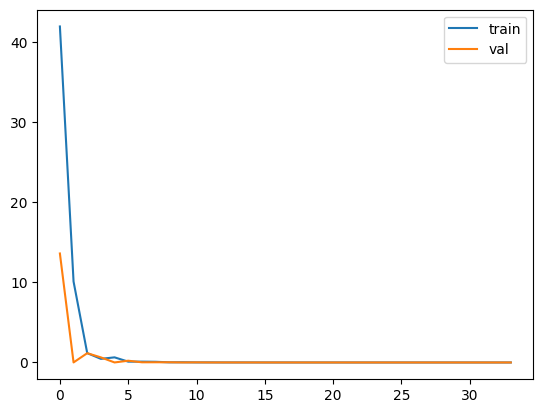

4/4 [==============================] - 0s 55ms/step
mae: 7.492418920574855
(126,)
(126,)


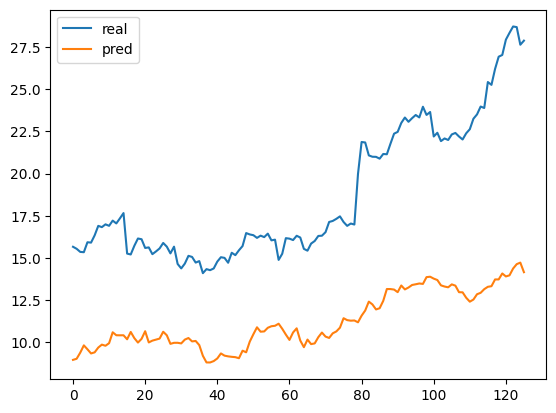

Epoch 1/1000
7/7 [==============================] - 4s 125ms/step - loss: 23.3150 - val_loss: 0.0228
Epoch 2/1000
7/7 [==============================] - 0s 20ms/step - loss: 2.5296 - val_loss: 0.1430
Epoch 3/1000
7/7 [==============================] - 0s 20ms/step - loss: 1.4236 - val_loss: 0.5592
Epoch 4/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.3234 - val_loss: 0.0185
Epoch 5/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.1590 - val_loss: 0.0519
Epoch 6/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0291 - val_loss: 0.0775
Epoch 7/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0156 - val_loss: 0.0123
Epoch 8/1000
7/7 [==============================] - 0s 21ms/step - loss: 0.0098 - val_loss: 0.0519
Epoch 9/1000
7/7 [==============================] - 0s 18ms/step - loss: 0.0068 - val_loss: 0.0174
Epoch 10/1000
7/7 [==============================] - 0s 20ms/step - loss: 0.0065 - val_loss: 0.0281
Epoch 1

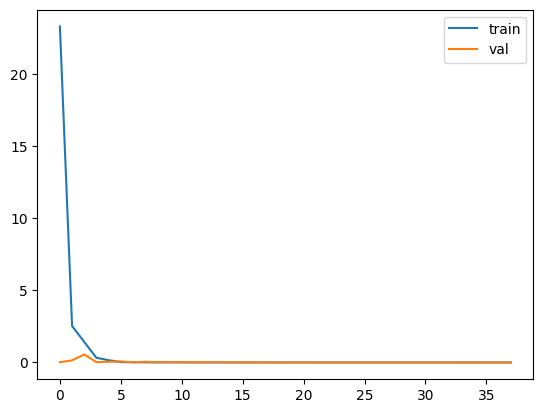

4/4 [==============================] - 0s 8ms/step
mae: 11.0087172537028
(126,)
(126,)


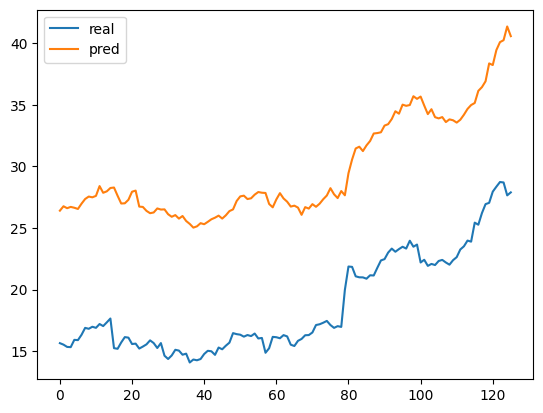

Epoch 1/1000
10/10 [==============================] - 4s 82ms/step - loss: 18.8058 - val_loss: 2.0109
Epoch 2/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.6226 - val_loss: 0.1495
Epoch 3/1000
10/10 [==============================] - 0s 18ms/step - loss: 1.0869 - val_loss: 0.2638
Epoch 4/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.2172 - val_loss: 0.4749
Epoch 5/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.3094 - val_loss: 0.0598
Epoch 6/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0406 - val_loss: 0.0335
Epoch 7/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 8/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 9/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0114 - val_loss: 0.0162
Epoch 10/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0070 - val_l

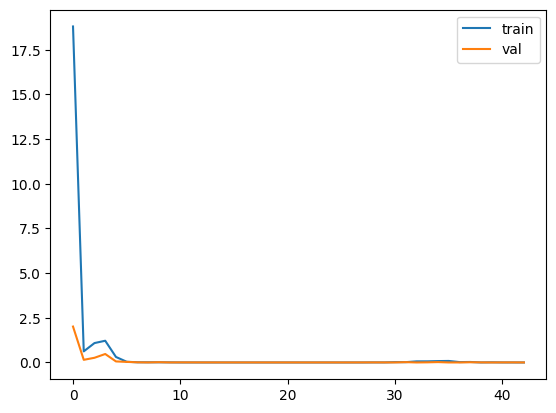

4/4 [==============================] - 0s 7ms/step
mae: 7.51321185898893
(126,)
(126,)


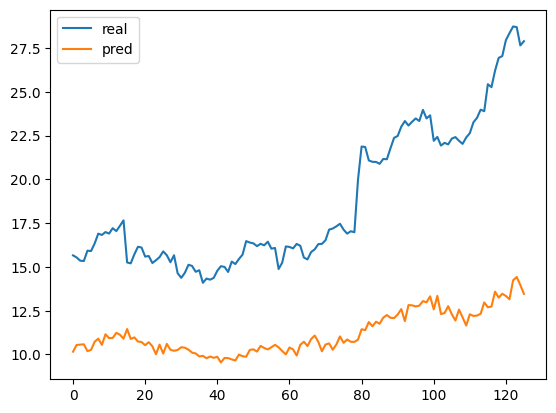

Epoch 1/1000
13/13 [==============================] - 5s 74ms/step - loss: 8.0620 - val_loss: 0.7588
Epoch 2/1000
13/13 [==============================] - 0s 17ms/step - loss: 0.6471 - val_loss: 0.5561
Epoch 3/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.1296 - val_loss: 0.3975
Epoch 4/1000
13/13 [==============================] - 0s 17ms/step - loss: 0.4015 - val_loss: 0.0837
Epoch 5/1000
13/13 [==============================] - 0s 15ms/step - loss: 0.7050 - val_loss: 0.1819
Epoch 6/1000
13/13 [==============================] - 0s 17ms/step - loss: 0.2865 - val_loss: 0.0616
Epoch 7/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.6102 - val_loss: 0.0315
Epoch 8/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.1082 - val_loss: 0.0193
Epoch 9/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0881 - val_loss: 0.0073
Epoch 10/1000
13/13 [==============================] - 0s 16ms/step - loss: 0.0286 - val_lo

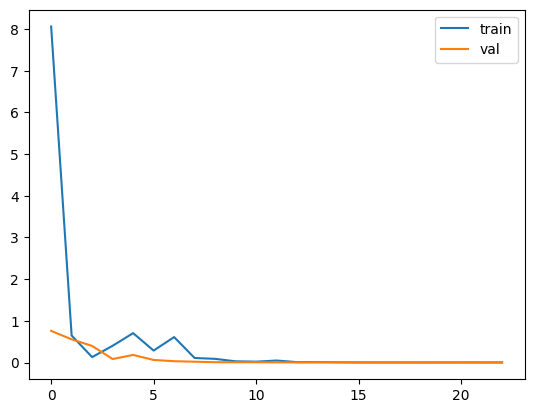

4/4 [==============================] - 0s 9ms/step
mae: 7.324097076443628
(126,)
(126,)


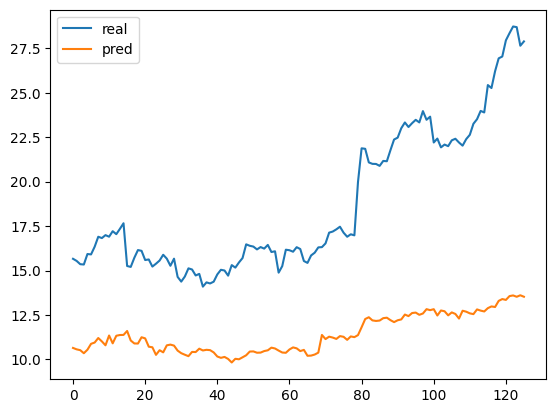

Epoch 1/1000
17/17 [==============================] - 5s 66ms/step - loss: 11.5568 - val_loss: 0.7557
Epoch 2/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.5691 - val_loss: 0.0037
Epoch 3/1000
17/17 [==============================] - 0s 17ms/step - loss: 0.2632 - val_loss: 0.1405
Epoch 4/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.2391 - val_loss: 0.1200
Epoch 5/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.4024 - val_loss: 0.0097
Epoch 6/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.0328 - val_loss: 0.0159
Epoch 7/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.0609 - val_loss: 0.0231
Epoch 8/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.2115 - val_loss: 0.3149
Epoch 9/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.1737 - val_loss: 0.6586
Epoch 10/1000
17/17 [==============================] - 0s 16ms/step - loss: 0.1130 - val_l

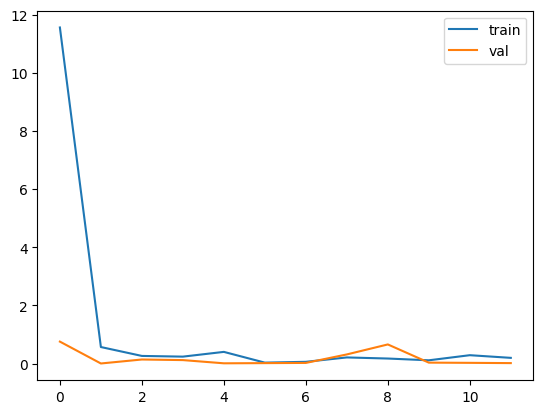

4/4 [==============================] - 0s 7ms/step
mae: 3.2419994294549848
(126,)
(126,)


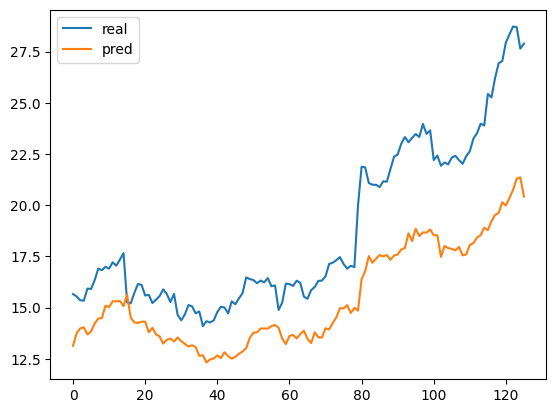

Epoch 1/1000
20/20 [==============================] - 4s 45ms/step - loss: 10.7487 - val_loss: 0.0192
Epoch 2/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.4848 - val_loss: 0.0240
Epoch 3/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.2642 - val_loss: 0.0855
Epoch 4/1000
20/20 [==============================] - 0s 16ms/step - loss: 0.3784 - val_loss: 0.0058
Epoch 5/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.3949 - val_loss: 0.0535
Epoch 6/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.2646 - val_loss: 0.1357
Epoch 7/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0426 - val_loss: 0.0072
Epoch 8/1000
20/20 [==============================] - 0s 16ms/step - loss: 0.2662 - val_loss: 0.0136
Epoch 9/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.1673 - val_loss: 0.0054
Epoch 10/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.0836 - val_l

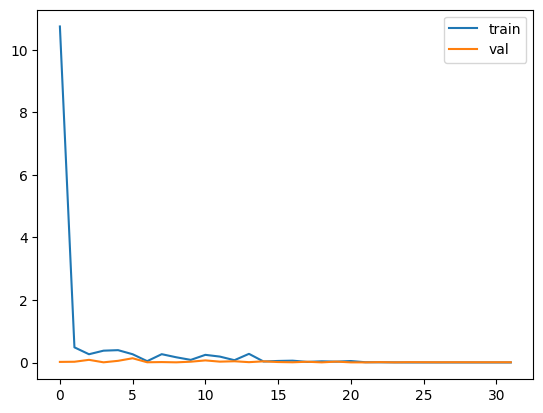

4/4 [==============================] - 0s 7ms/step
mae: 0.6483291855478438
(126,)
(126,)


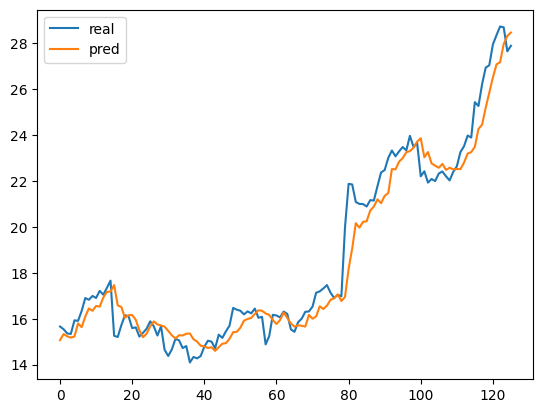

Epoch 1/1000
23/23 [==============================] - 5s 45ms/step - loss: 6.2095 - val_loss: 0.2313
Epoch 2/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.3143 - val_loss: 0.0773
Epoch 3/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.4387 - val_loss: 0.9183
Epoch 4/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.3351 - val_loss: 0.4526
Epoch 5/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.7265 - val_loss: 0.0058
Epoch 6/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0924 - val_loss: 0.0097
Epoch 7/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.1169 - val_loss: 0.0901
Epoch 8/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0259 - val_loss: 0.0207
Epoch 9/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0620 - val_loss: 0.0430
Epoch 10/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.1336 - val_lo

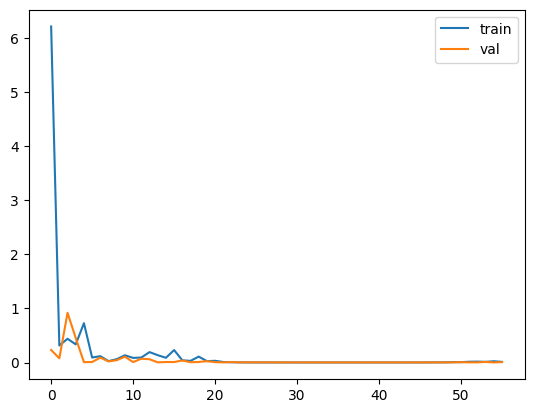

4/4 [==============================] - 0s 8ms/step
mae: 2.9315484560130285
(126,)
(126,)


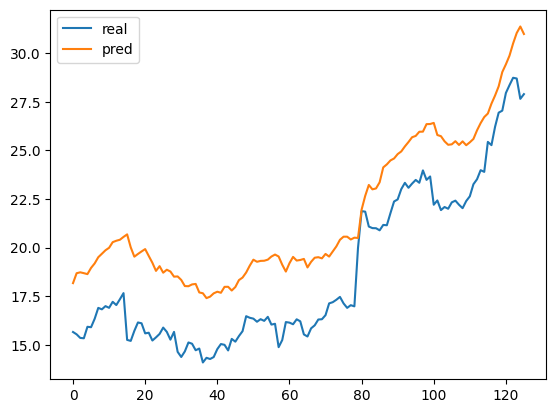

Epoch 1/1000
26/26 [==============================] - 4s 41ms/step - loss: 4.2477 - val_loss: 0.0191
Epoch 2/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.1262 - val_loss: 0.3652
Epoch 3/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0959 - val_loss: 0.2340
Epoch 4/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.5725 - val_loss: 0.0180
Epoch 5/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.1341 - val_loss: 0.0719
Epoch 6/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.1385 - val_loss: 0.0343
Epoch 7/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.2221 - val_loss: 0.0337
Epoch 8/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0743 - val_loss: 0.0069
Epoch 9/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.1401 - val_loss: 0.0055
Epoch 10/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.1179 - val_lo

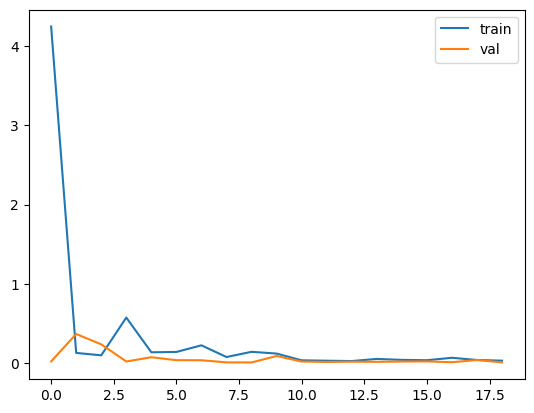

4/4 [==============================] - 0s 7ms/step
mae: 0.7944762361934603
(126,)
(126,)


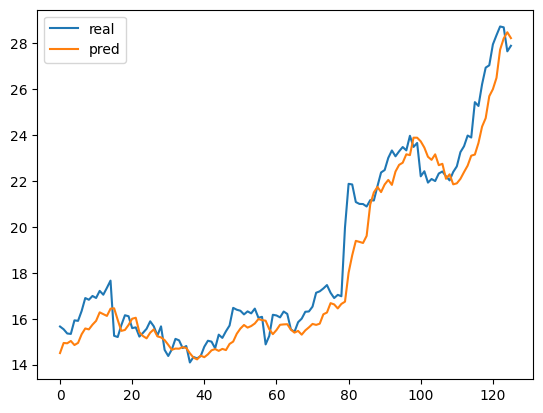

Epoch 1/1000
29/29 [==============================] - 5s 49ms/step - loss: 4.6541 - val_loss: 0.0110
Epoch 2/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0770 - val_loss: 0.0527
Epoch 3/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0505 - val_loss: 0.1381
Epoch 4/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.1942 - val_loss: 0.0205
Epoch 5/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.1867 - val_loss: 0.0327
Epoch 6/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.1359 - val_loss: 0.1765
Epoch 7/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0657 - val_loss: 0.1162
Epoch 8/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0233 - val_loss: 0.0262
Epoch 9/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0714 - val_loss: 0.0382
Epoch 10/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0851 - val_lo

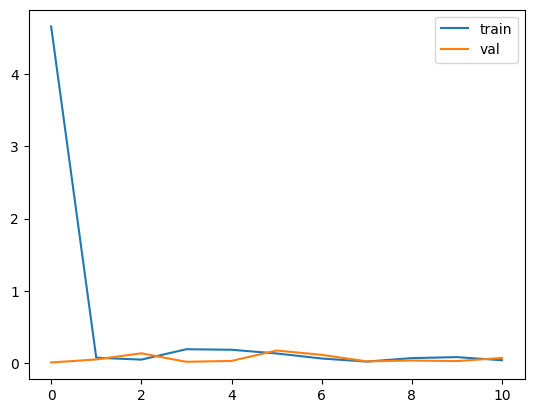

4/4 [==============================] - 0s 7ms/step
mae: 15.433624650412908
(126,)
(126,)


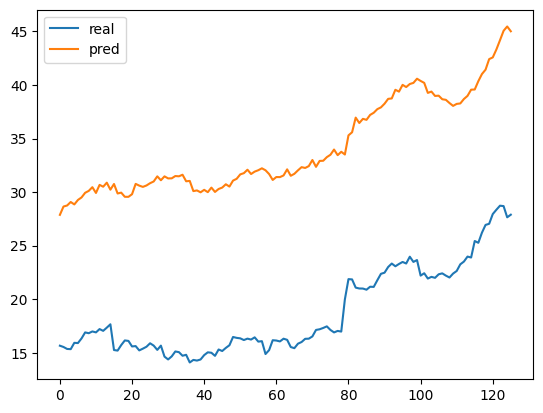

Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 4.9157

2023-11-06 20:54:32.802509: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 578.85MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 5s 34ms/step - loss: 4.9157 - val_loss: 0.2610
Epoch 2/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.2203 - val_loss: 0.1470
Epoch 3/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.0792 - val_loss: 0.0071
Epoch 4/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.1071 - val_loss: 0.0566
Epoch 5/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.3526 - val_loss: 0.0425
Epoch 6/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.2870 - val_loss: 0.0523
Epoch 7/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.1052 - val_loss: 0.0501
Epoch 8/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.1314 - val_loss: 0.0392
Epoch 9/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0227
Epoch 10/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.1108 - val_loss: 0.0230
Ep

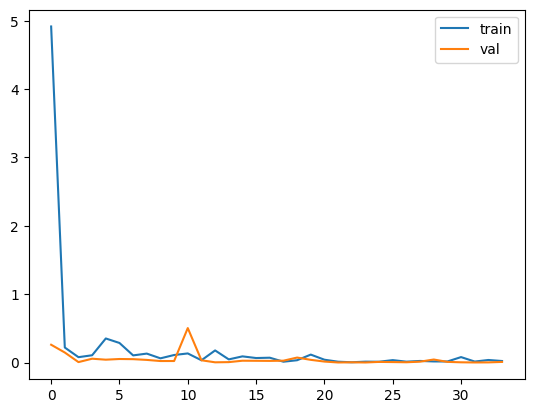

4/4 [==============================] - 0s 6ms/step
mae: 2.087513122139098
(126,)
(126,)


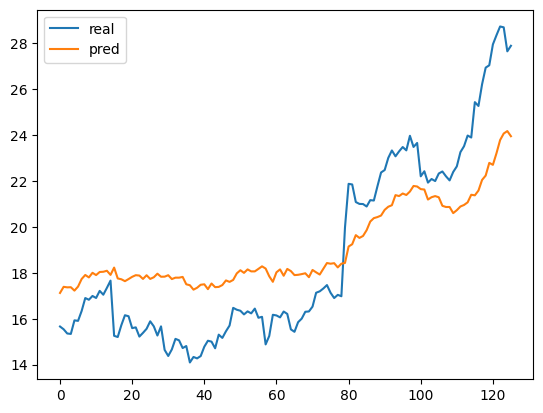

In [18]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model=Sequential()
    model.add(
Bidirectional(
     TCN(
         input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_size=7,
         dilations=[1, 2, 4, 8, 16],
         return_sequences=False,
        activation='relu',
            nb_filters=258,
         padding='causal',
         #dropout_rate=0.25,
         kernel_initializer='he_normal',
     )   
    ))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam',loss='mse')
  
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape
    #accuracy and other metrics
    pred=np.repeat(y_pred,16,axis=1)

    pred=scaler.inverse_transform(pred)[:,-1]
    
    #print mae for pred and y_test
    print('mae:',np.mean(np.abs(pred-y_test)))

    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
